In [223]:
import pandas as pd
import numpy as np
import zipcodes
import requests
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt

## CSV Read/Write and Dataframe Declaration

In [2]:
# reads in original csv file of most recent trip data to maintain relevance
df_bluebikes = pd.read_csv('data/202303-bluebikes-tripdata.csv')
df_bluebikes

# filter out stations by postal code
# 30 minute intervals
print(df_bluebikes.shape)
df_bluebikes.head(10)

(199003, 14)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,1105,2023-03-01 00:00:44.1520,2023-03-01 00:19:09.9080,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,403,Marion St at Harvard St,42.340122,-71.120706,6680,Subscriber,02139
1,415,2023-03-01 00:01:45.6530,2023-03-01 00:08:41.5960,12,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,30,Brigham Circle - Francis St at Huntington Ave,42.334629,-71.104079,8142,Subscriber,02072
2,169,2023-03-01 00:03:54.2260,2023-03-01 00:06:43.6980,12,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,160,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,4727,Subscriber,02115
3,624,2023-03-01 00:04:13.8340,2023-03-01 00:14:38.0830,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,378,191 Beacon St,42.380323,-71.108786,6044,Subscriber,02139
4,1116,2023-03-01 00:05:04.3640,2023-03-01 00:23:40.5370,554,Forsyth St at Huntington Ave,42.339202,-71.090511,282,Stony Brook T Stop,42.316966,-71.104374,3724,Subscriber,02130
5,485,2023-03-01 00:05:19.3490,2023-03-01 00:13:24.9100,141,Kendall Street,42.363560,-71.082168,335,Harvard St at Greene-Rose Heritage Park,42.365994,-71.095222,5201,Subscriber,63017
6,372,2023-03-01 00:05:42.5770,2023-03-01 00:11:54.8490,554,Forsyth St at Huntington Ave,42.339202,-71.090511,379,Tremont St at W. Dedham St,42.342549,-71.074214,7441,Subscriber,02118
7,310,2023-03-01 00:07:52.0290,2023-03-01 00:13:02.6280,361,Deerfield St at Commonwealth Ave,42.349244,-71.097282,452,1200 Beacon St,42.344149,-71.114674,2048,Subscriber,02139
8,39772,2023-03-01 00:08:46.8850,2023-03-01 11:11:39.7260,140,Danehy Park,42.388966,-71.132788,118,Linear Park - Mass. Ave. at Cameron Ave.,42.397828,-71.130516,2007,Subscriber,02140
9,268,2023-03-01 00:09:16.6710,2023-03-01 00:13:44.8920,75,Lafayette Square at Mass Ave / Main St / Colum...,42.363465,-71.100573,515,955 Mass Ave,42.368952,-71.109988,4190,Subscriber,02139


In [3]:
# reads in the current bluebike stations csv
df_cur_stations = pd.read_csv('data/current_bluebikes_stations.csv', header=1)
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
443,N32005,West Newton,42.349601,-71.226275,Newton,Yes,14,2020.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
446,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23,2018.0


In [4]:
list(df_bluebikes['end station name'].values)

# finds the set of stations that are not shared in both datasets
set_names = set()

for name in df_bluebikes['end station name'].values:
    if name in df_cur_stations['Name'].values:
        pass
    else:
        set_names.add(name)

In [5]:
set_names

{'18 Dorrance Warehouse',
 '87-101 Cambridgepark Drive',
 'Ball Sq',
 'Beacon St at Washington / Kirkland',
 'Boylston St at Charles St (Temp Winter Location)',
 'Boynton Yards at 101 South Street',
 'Broadway T Stop',
 'Craigie at Summer St',
 'Graham and Parks School – Linnaean St at Walker St',
 'Linear Park - Mass. Ave. at Cameron Ave. ',
 'Riverway at Brookline Ave',
 'Somerville Hospital',
 'Washington St at Myrtle St'}

In [6]:
# changes the naming conventions to match the stations across both datasets
df_cur_stations['Name'] = df_cur_stations['Name'].replace('Graham and Parks School ? Linnaean St at Walker St',
                                          'Graham and Parks School - Linnaean St at Walker St')
df_cur_stations['Name'] = df_cur_stations['Name'].replace('Linear Park - Mass. Ave. at Cameron Ave.',
                                          'Linear Park - Mass. Ave. at Cameron Ave. ')
df_cur_stations['Name'] = df_cur_stations['Name'].replace('Boylston St at Charles St (Temp Winter Location)',
                                          'Boylston St at Charles St')
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
443,N32005,West Newton,42.349601,-71.226275,Newton,Yes,14,2020.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
446,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23,2018.0


In [7]:
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
443,N32005,West Newton,42.349601,-71.226275,Newton,Yes,14,2020.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
446,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23,2018.0


In [8]:
filtered_zips = zipcodes.filter_by(city="Boston", state="MA") 
filtered_zips

# finds a list of the zipcodes in Boston to filter by region
boston_zips_list = []

for i in filtered_zips:
    boston_zips_list.append(i['zip_code'])
    
len(boston_zips_list)

37

In [9]:
# filters the dataset to only include Boston region
df_cur_stations = df_cur_stations.loc[df_cur_stations['District'] == 'Boston']
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
...,...,...,...,...,...,...,...,...
441,B32021,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,Boston,Yes,14,2015.0
442,D32022,West End Park,42.365908,-71.064467,Boston,Yes,35,2012.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0


Speeding up station lookup using a dictionary:

In [10]:
bos_station_dict = {}
for idx, s in df_cur_stations.iterrows():
    bos_station_dict[s['Name']] = idx
print(bos_station_dict)

{'175 N Harvard St': 2, '2 Hummingbird Lane at Olmsted Green': 4, '555 Metropolitan Ave': 8, '606 American Legion Hwy at Canterbury St': 9, '645 Summer St': 10, '700 Commonwealth Ave.': 13, 'Adams Branch Library': 19, 'Adams St at Lonsdale St': 20, 'Addison St at Saratoga St': 21, 'Airport T Stop - Bremen St at Brooks St': 22, 'Albany St at E. Brookline St': 23, 'American Legion Hwy at Cummins Hwy': 26, 'American Legion Hwy at Hyde Park Ave': 27, 'Andrew T Stop - Dorchester Ave at Dexter St': 30, 'Aquarium T Stop - 200 Atlantic Ave': 31, 'Arch St at Franklin St': 32, 'Archdale Rd at Washington St': 33, 'Ashmont T Stop': 35, 'B.U. Central - 725 Comm. Ave.': 38, 'Back Bay T Stop - Dartmouth St at Stuart St': 39, 'Bartlett St at John Elliot Sq': 41, 'Beacon St at Charles St': 43, 'Beacon St at Massachusetts Ave': 44, 'Belgrade Ave at Walworth St': 46, 'Bellevue T Stop': 47, 'Bennington St at Byron St': 49, 'Bennington St at Constitution Beach': 50, 'Blossom St at Charles St': 53, 'Blue Hi

In [47]:
# filters the history data by Boston region
df_bluebikes = df_bluebikes.loc[df_bluebikes['postal code'].isin(boston_zips_list)]
df_bluebikes

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,day_of_week
1,2,169,2023-03-01 00:03:54.226,2023-03-01 00:06:43.698,12,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,160,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,4727,Subscriber,02115,2
3,6,372,2023-03-01 00:05:42.577,2023-03-01 00:11:54.849,554,Forsyth St at Huntington Ave,42.339202,-71.090511,379,Tremont St at W. Dedham St,42.342549,-71.074214,7441,Subscriber,02118,2
6,11,593,2023-03-01 00:11:32.693,2023-03-01 00:21:26.027,554,Forsyth St at Huntington Ave,42.339202,-71.090511,558,St. Alphonsus St at Tremont St,42.333293,-71.101246,7345,Subscriber,02115,2
15,25,349,2023-03-01 00:21:39.269,2023-03-01 00:27:28.975,554,Forsyth St at Huntington Ave,42.339202,-71.090511,27,Roxbury Crossing T Stop - Columbus Ave at Trem...,42.331184,-71.095171,3743,Subscriber,02118,2
20,32,1086,2023-03-01 00:30:26.302,2023-03-01 00:48:32.341,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,14,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,42.337417,-71.102861,8473,Subscriber,02115,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122781,198985,201,2023-03-31 23:48:14.563,2023-03-31 23:51:35.933,228,One Memorial Drive,42.361619,-71.080436,60,Charles Circle - Charles St at Cambridge St,42.360793,-71.071190,3660,Subscriber,02114,4
122783,198990,769,2023-03-31 23:52:43.229,2023-04-01 00:05:33.091,338,Commonwealth Ave at Kelton St,42.348359,-71.139972,19,Park Dr at Buswell St,42.347241,-71.105301,7315,Subscriber,02215,4
122784,198991,3711,2023-03-31 23:52:49.124,2023-04-01 00:54:40.212,128,E Cottage St at Columbia Rd,42.320561,-71.061980,128,E Cottage St at Columbia Rd,42.320561,-71.061980,4446,Subscriber,02109,4
122786,198995,2663,2023-03-31 23:54:24.093,2023-04-01 00:38:47.372,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,7701,Customer,02215,4


In [48]:
# saves to csv
df_bluebikes.to_csv('data/boston_202303_bluebikes_tripdata.csv')
df_cur_stations.to_csv('data/boston_current_bluebike_stations.csv')

In [49]:
# reads in the updated csv
df_bluebikes = pd.read_csv('data/boston_202303_bluebikes_tripdata.csv')
df_cur_stations = pd.read_csv('data/boston_current_bluebike_stations.csv')

## JSON Testing

In [157]:
request = requests.get("https://gbfs.bluebikes.com/gbfs/en/station_information.json")
print(request.json())

{'data': {'stations': [{'station_type': 'classic', 'capacity': 14, 'lon': -71.10061883926392, 'station_id': '3', 'short_name': 'B32006', 'legacy_id': '3', 'eightd_station_services': [], 'eightd_has_key_dispenser': True, 'region_id': '10', 'external_id': 'f83464e4-0de8-11e7-991c-3863bb43a7d0', 'electric_bike_surcharge_waiver': False, 'name': 'Colleges of the Fenway - Fenway at Avenue Louis Pasteur', 'lat': 42.34011512249236, 'has_kiosk': True, 'rental_methods': ['CREDITCARD', 'KEY']}, {'station_type': 'classic', 'capacity': 19, 'lon': -71.069616, 'station_id': '4', 'short_name': 'C32000', 'legacy_id': '4', 'eightd_station_services': [], 'eightd_has_key_dispenser': False, 'region_id': '10', 'external_id': 'f834658f-0de8-11e7-991c-3863bb43a7d0', 'electric_bike_surcharge_waiver': False, 'name': 'Tremont St at E Berkeley St', 'lat': 42.345392, 'has_kiosk': True, 'rental_methods': ['CREDITCARD', 'KEY']}, {'station_type': 'classic', 'capacity': 15, 'lon': -71.090179, 'station_id': '5', 'short

In [169]:
request.json()['data']['stations'][100]

{'station_type': 'classic',
 'capacity': 15,
 'lon': -71.123413,
 'station_id': '111',
 'short_name': 'S32009',
 'legacy_id': '111',
 'eightd_station_services': [],
 'eightd_has_key_dispenser': False,
 'region_id': '9',
 'external_id': 'f834c6f5-0de8-11e7-991c-3863bb43a7d0',
 'electric_bike_surcharge_waiver': False,
 'name': 'Packard Ave at Powderhouse Blvd',
 'lat': 42.40449,
 'has_kiosk': True,
 'rental_methods': ['CREDITCARD', 'KEY']}

In [16]:
kiosk_list = []
for i in request.json()['data']['stations']:
    kiosk_list.append(i['has_kiosk'])
    
kiosk_list[:10]

[True, True, True, True, True, True, True, True, True, True]

In [17]:
request2 = requests.get("https://gbfs.bluebikes.com/gbfs/fr/free_bike_status.json")
request2.json()

{'data': {'bikes': []}, 'last_updated': 1680972245, 'ttl': 5}

In [18]:
request3 = requests.get("https://gbfs.bluebikes.com/gbfs/en/system_calendar.json")
request3.json()

{'data': {'calendars': [{'start_month': 1,
    'end_month': 12,
    'start_day': 1,
    'end_day': 31}]},
 'last_updated': 1680972245,
 'ttl': 5}

## Deriving Attributes: Date and Time

In [50]:
df_bluebikes['starttime'] = df_bluebikes['starttime'].apply(lambda x : dt.datetime.strptime(x, 
                                              '%Y-%m-%d %H:%M:%S.%f'))
df_bluebikes['stoptime'] = df_bluebikes['stoptime'].apply(lambda x : dt.datetime.strptime(x, 
                                              '%Y-%m-%d %H:%M:%S.%f'))

In [51]:
df_bluebikes['day_of_week'] = df_bluebikes['starttime'].dt.dayofweek

In [52]:
df_bluebikes.loc[df_bluebikes['start station name'] == '175 N Harvard St']

,Unnamed: 0,Unnamed: 0.1,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,day_of_week
1101,3801,6087,666,2023-03-01 20:43:44.397,2023-03-01 20:54:50.763,149,175 N Harvard St,42.363796,-71.129164,103,JFK Crossing at Harvard St. / Thorndike St.,42.346551,-71.128332,6487,Subscriber,2215,2
1719,6027,9941,879,2023-03-02 17:50:56.137,2023-03-02 18:05:35.422,149,175 N Harvard St,42.363796,-71.129164,69,Coolidge Corner - Beacon St at Centre St,42.341598,-71.123338,8202,Subscriber,2215,3
2018,7057,11626,2183,2023-03-02 20:21:45.612,2023-03-02 20:58:09.070,149,175 N Harvard St,42.363796,-71.129164,591,515 Somerville Ave (Temp. Winter Location),42.383227,-71.106069,2509,Subscriber,2163,3
2031,7118,11732,272,2023-03-02 20:38:13.216,2023-03-02 20:42:45.229,149,175 N Harvard St,42.363796,-71.129164,17,Soldiers Field Park - 111 Western Ave,42.364263,-71.118276,6751,Subscriber,2163,3
2621,9247,15286,548,2023-03-03 14:19:51.690,2023-03-03 14:29:00.611,149,175 N Harvard St,42.363796,-71.129164,108,Harvard University / SEAS Cruft-Pierce Halls a...,42.377945,-71.116865,6720,Subscriber,2163,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30965,112660,183256,555,2023-03-29 17:53:15.706,2023-03-29 18:02:31.553,149,175 N Harvard St,42.363796,-71.129164,8,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,2715,Subscriber,2163,2
31289,113690,184873,1348,2023-03-29 20:22:04.160,2023-03-29 20:44:33.070,149,175 N Harvard St,42.363796,-71.129164,25,South End Library - Tremont St at W Newton St,42.341332,-71.076847,3624,Subscriber,2118,2
31347,113882,185185,130,2023-03-29 21:20:58.361,2023-03-29 21:23:09.230,149,175 N Harvard St,42.363796,-71.129164,492,Harvard Stadium: N. Harvard St at Soldiers Fie...,42.368019,-71.124200,3259,Subscriber,2163,2
32035,116472,189079,410,2023-03-30 15:37:50.767,2023-03-30 15:44:41.615,149,175 N Harvard St,42.363796,-71.129164,8,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,2485,Subscriber,2115,3


In [53]:
df_bluebikes.to_csv('data/boston_bluebikes_202303_datetimes.csv')

In [54]:
len(pd.unique(df_cur_stations['Number']))

250

In [55]:
df_cur_stations

,Unnamed: 0,Unnamed: 0.1,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,0,2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
1,1,4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
2,2,8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
3,3,9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
4,4,10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
...,...,...,...,...,...,...,...,...,...,...
245,245,441,B32021,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,Boston,Yes,14,2015.0
246,246,442,D32022,West End Park,42.365908,-71.064467,Boston,Yes,35,2012.0
247,247,444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
248,248,445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0


### Dividing into time buckets

In [119]:
df_bluebikes['starttime'].max()

Timestamp('2023-03-31 23:58:04.497000')

In [57]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

timestamps = list(perdelta(dt.datetime(2023, 3, 1, 0), dt.datetime(2023, 4, 1, 0), dt.timedelta(hours=1)))

In [58]:
timestamps[:10]

[datetime.datetime(2023, 3, 1, 0, 0),
 datetime.datetime(2023, 3, 1, 1, 0),
 datetime.datetime(2023, 3, 1, 2, 0),
 datetime.datetime(2023, 3, 1, 3, 0),
 datetime.datetime(2023, 3, 1, 4, 0),
 datetime.datetime(2023, 3, 1, 5, 0),
 datetime.datetime(2023, 3, 1, 6, 0),
 datetime.datetime(2023, 3, 1, 7, 0),
 datetime.datetime(2023, 3, 1, 8, 0),
 datetime.datetime(2023, 3, 1, 9, 0)]

In [59]:
stations = list(df_cur_stations['Name'])

In [60]:
dict_main = {'station' : [], 'timestamp' : [], 'weekday' : [], 'hour' : []}
for station in stations:
    for timestamp in timestamps:
        dict_main['station'].append(station)
        dict_main['timestamp'].append(timestamp)
        dict_main['weekday'].append(timestamp.weekday())
        dict_main['hour'].append(timestamp.hour)
dict_main

{'station': ['175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',

In [61]:
df_main = pd.DataFrame(dict_main)
df_main

,station,timestamp,weekday,hour
0,175 N Harvard St,2023-03-01 00:00:00,2,0
1,175 N Harvard St,2023-03-01 01:00:00,2,1
2,175 N Harvard St,2023-03-01 02:00:00,2,2
3,175 N Harvard St,2023-03-01 03:00:00,2,3
4,175 N Harvard St,2023-03-01 04:00:00,2,4
...,...,...,...,...
185995,Williams St at Washington St,2023-03-31 19:00:00,4,19
185996,Williams St at Washington St,2023-03-31 20:00:00,4,20
185997,Williams St at Washington St,2023-03-31 21:00:00,4,21
185998,Williams St at Washington St,2023-03-31 22:00:00,4,22


## Deriving Dock Counts

In [62]:
df_main['docks'] = 0

In [120]:
df_main

,station,timestamp,weekday,hour,docks
0,175 N Harvard St,2023-03-01 00:00:00,2,0,25
1,175 N Harvard St,2023-03-01 01:00:00,2,1,25
2,175 N Harvard St,2023-03-01 02:00:00,2,2,25
3,175 N Harvard St,2023-03-01 03:00:00,2,3,25
4,175 N Harvard St,2023-03-01 04:00:00,2,4,25
...,...,...,...,...,...
185995,Williams St at Washington St,2023-03-31 19:00:00,4,19,6
185996,Williams St at Washington St,2023-03-31 20:00:00,4,20,6
185997,Williams St at Washington St,2023-03-31 21:00:00,4,21,6
185998,Williams St at Washington St,2023-03-31 22:00:00,4,22,6


The commented code below was meant to check whether EITHER the start or end stations are in Boston (rather than both). The problem here is likely that the system autofilters mass bike movement done by Bluebike employees. In other words, many people may bike from Boston to Cambridge, but not bike back, so employees need to bring the bikes back to Boston (which is not logged in the trip records).

In [206]:
for index, record in df_bluebikes.iterrows():
    # if start station is in Boston:
    # if bos_station_dict.get(record['start station name']):
        # df_main.loc[(df_main['station']==record['start station name']) & (df_main['timestamp']>=record['starttime']), 'docks'] += 1
    # if end station is in Boston:
    # if bos_station_dict.get(record['end station name']):
        # df_main.loc[(df_main['station']==record['end station name']) & (df_main['timestamp']>=record['stoptime']), 'docks'] -= 1
    df_main.loc[(df_main['station']==record['start station name']) & (df_main['timestamp']>=record['starttime']), 'docks'] += 1
    df_main.loc[(df_main['station']==record['end station name']) & (df_main['timestamp']>=record['stoptime']), 'docks'] -= 1

KeyboardInterrupt: 

In [216]:
df_main

,station,timestamp,weekday,hour,docks
0,175 N Harvard St,2023-03-01 00:00:00,2,0,25
1,175 N Harvard St,2023-03-01 01:00:00,2,1,25
2,175 N Harvard St,2023-03-01 02:00:00,2,2,25
3,175 N Harvard St,2023-03-01 03:00:00,2,3,25
4,175 N Harvard St,2023-03-01 04:00:00,2,4,25
...,...,...,...,...,...
185995,Williams St at Washington St,2023-03-31 19:00:00,4,19,6
185996,Williams St at Washington St,2023-03-31 20:00:00,4,20,6
185997,Williams St at Washington St,2023-03-31 21:00:00,4,21,6
185998,Williams St at Washington St,2023-03-31 22:00:00,4,22,6


In [68]:
for index, record in df_cur_stations.iterrows():
    df_main.loc[(df_main['station']==record['Name']), 'docks'] -= df_main[(df_main['station'] == record['Name'])]['docks'].min()

In [77]:
df_cur_stations.loc[df_cur_stations['Name'] == '175 N Harvard St']

,Unnamed: 0,Unnamed: 0.1,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,0,2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0


In [103]:

def regularize_stations(df, station_name, max_docks: int):
    counter = 0
    station_buckets = df.loc[df['station'] == station_name]
    for idx, station in station_buckets.iterrows():
        if station['docks'] > max_docks:
            counter += 1
    print(counter)
    print(idx)
    return

station = '175 N Harvard St'
regularize_stations(
    df_main,
    station, 
    df_cur_stations.loc[df_cur_stations['Name'] == station, 'Total docks'][0])


207
743


In [282]:
df_main_filtered = df_main.copy()
count = 0
for index, record in df_cur_stations.iterrows():
    if (record['Total docks'] < df_main_filtered[df_main_filtered['station']==record['Name']]['docks'].max() 
    or df_main_filtered.loc[df_main_filtered['station'] == record['Name']]['docks'].sum() == 0):
        df_main_filtered = df_main_filtered[df_main_filtered['station'] != record['Name']]
        count +=1
df_main_filtered = df_main_filtered.reset_index(drop=True)
print(count)

156


In [283]:
df_main_filtered['docks'].describe()

count    69936.000000
mean         3.627459
std          3.711899
min         -1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         21.000000
Name: docks, dtype: float64

In [277]:
len(pd.unique(df_main_filtered['station']))

94

Most of the docks arent accurate and there could be 2 main reasons. One of them could be because we are filtering out any station that is not in Boston. Therefore if someone cycles from Boston to Waltham, there will only be a start but no end in our data. Another reason could be that at a station, there is no point in our data set where the docks are completely empty AND full. 

## Feature Selection and Training

### Deriving Features from df_main_filtered

In [134]:
# adds the popularity feature to the current stations dataframe
def popularity(station_name):
    trips = df_bluebikes.loc[(df_bluebikes['start station name'] == station_name) | (df_bluebikes['end station name'] == station_name)]
    trip_count = trips.shape[0]
    return trip_count / df_bluebikes.shape[0]

print(popularity('175 N Harvard St'))
print(popularity('this is not a real station'))

0.003502419043661512
0.0


In [278]:
df_cur_stations.head(10)

,Unnamed: 0,Unnamed: 0.1,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,0,2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
1,1,4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
2,2,8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
3,3,9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
4,4,10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
5,5,13,B32060,700 Commonwealth Ave.,42.349609,-71.103915,Boston,Yes,16,2019.0
6,6,19,C32098,Adams Branch Library,42.286011,-71.054689,Boston,Yes,0,2021.0
7,7,20,C32065,Adams St at Lonsdale St,42.291679,-71.057263,Boston,Yes,0,2019.0
8,8,21,A32054,Addison St at Saratoga St,42.385181,-71.015137,Boston,Yes,0,2022.0
9,9,22,A32032,Airport T Stop - Bremen St at Brooks St,42.374103,-71.032764,Boston,Yes,11,2016.0


In [213]:
df_bluebikes.head(3)

,Unnamed: 0,Unnamed: 0.1,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,day_of_week
0,1,2,169,2023-03-01 00:03:54.226,2023-03-01 00:06:43.698,12,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,160,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,4727,Subscriber,2115,2
1,3,6,372,2023-03-01 00:05:42.577,2023-03-01 00:11:54.849,554,Forsyth St at Huntington Ave,42.339202,-71.090511,379,Tremont St at W. Dedham St,42.342549,-71.074214,7441,Subscriber,2118,2
2,6,11,593,2023-03-01 00:11:32.693,2023-03-01 00:21:26.027,554,Forsyth St at Huntington Ave,42.339202,-71.090511,558,St. Alphonsus St at Tremont St,42.333293,-71.101246,7345,Subscriber,2115,2


In [287]:
df_main_filtered

,station,timestamp,weekday,hour,docks
0,645 Summer St,2023-03-01 00:00:00,2,0,0
1,645 Summer St,2023-03-01 01:00:00,2,1,0
2,645 Summer St,2023-03-01 02:00:00,2,2,0
3,645 Summer St,2023-03-01 03:00:00,2,3,0
4,645 Summer St,2023-03-01 04:00:00,2,4,0
...,...,...,...,...,...
69931,Williams St at Washington St,2023-03-31 19:00:00,4,19,6
69932,Williams St at Washington St,2023-03-31 20:00:00,4,20,6
69933,Williams St at Washington St,2023-03-31 21:00:00,4,21,6
69934,Williams St at Washington St,2023-03-31 22:00:00,4,22,6


In [210]:
df_cur_stations.loc[df_cur_stations['Name'] == df_main_filtered.iloc[772]['station']]['Total docks'].iloc[0]

11

In [297]:
def feature_vector(time_bucket, idx):
    # popularity of station
    # total docks
    # time of day
    # weekday
    # change in bikes (before)
    # y: predicted current number of bikes
    station_row = df_cur_stations.loc[df_cur_stations['Name'] == time_bucket['station']]

    popularity_val = popularity(time_bucket['station'])
    total_docks = station_row['Total docks'].iloc[0]
    hour = time_bucket['hour']
    weekday = time_bucket['weekday']
    
    if time_bucket['timestamp'] == datetime.datetime(2023, 3, 1, 0, 0): # if March 1 at midnight:
        return # no data for previous hour, so can't generate feature vector
    else:
        change_in_bikes_hour = df_main_filtered.iloc[idx - 1]['docks']
    
    if time_bucket['timestamp'] <= datetime.datetime(2023, 3, 2, 0, 0): # if before March 2 at midnight:
        return # no data for previous day, so can't generate feature vector
    else:
        change_in_bikes_day = df_main_filtered.iloc[idx - 24]['docks']
    
    feature_vec = [popularity_val, total_docks, hour, weekday, change_in_bikes_hour, change_in_bikes_day]
    return feature_vec

    
print(df_main_filtered.iloc[500])
print(feature_vector(df_main_filtered.iloc[500], 0))
    
    

station            645 Summer St
timestamp    2023-03-21 20:00:00
weekday                        1
hour                          20
docks                          4
Name: 500, dtype: object
[0.0023151583508948977, 19, 20, 1, 6, 5]


In [298]:
features_df = []
outputs = []

for idx, row in df_main_filtered.iterrows():
    try:
        vector = feature_vector(row, idx)
    except:
        print(idx)
        break
    if vector != None:
        features_df.append(vector)
        outputs.append(row['docks'])

# creating training and testing data
x_train, x_test, y_train, y_test = train_test_split(features_df, outputs, test_size=0.25)
    
reg = LinearRegression().fit(x_train, y_train)
ypred = reg.predict(x_test)

In [314]:
x_total_docks_test = [a[1] for a in x_test]

Text(0.5, 1.0, 'Predicted Docks vs Features with Linear Regression')

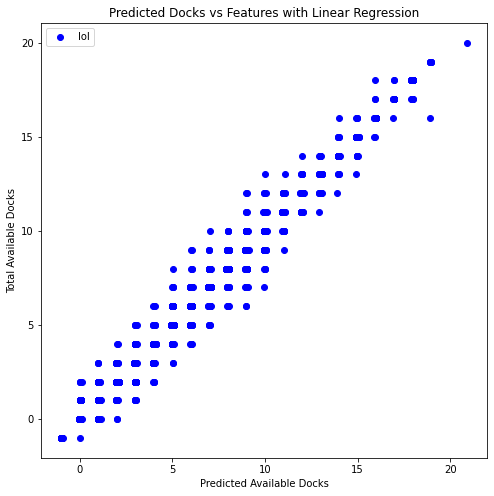

In [319]:
import matplotlib.pyplot as plt

plt.scatter(ypred, y_test, color = 'blue', marker='o', label='lol')
plt.legend()
plt.gcf().set_size_inches(8, 8)
plt.xlabel('Predicted Available Docks')
plt.ylabel('Total Available Docks')
plt.title('Predicted Docks vs Features with Linear Regression')